## TEC marker plotting and frequency analyses 

In [1]:
import sys 
import os
from datetime import datetime

import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
#import scvi
import hdf5plugin

import matplotlib.pyplot as plt
import seaborn as sns

# Add repo path to sys path (allows to access scripts and metadata from repo)
repo_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/TEC_compartment'
sys.path.insert(1, repo_path) 
sys.path.insert(2, '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts')


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

In [3]:
# Define plot and path dirs
plot_path = os.path.join(repo_path, 'plots')
data_path = os.path.join(repo_path, 'data')
results_path = os.path.join(repo_path, 'results')
model_path = os.path.join(repo_path, 'models')
general_data_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/data'

In [4]:
# Formatting
from matplotlib import font_manager
font_manager.fontManager.addfont("/nfs/team205/ny1/ThymusSpatialAtlas/software/Arial.ttf")
#plt.style.use('/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')

# Import custom scripts
from utils import get_latest_version,update_obs,freq_by_donor
from anno_levels import get_ct_levels, get_ct_palette, age_group_levels, age_group_palette
from plotting.utils import plot_grouped_boxplot, calc_figsize

In [5]:
sc.settings.set_figure_params(dpi = 80, color_map = 'RdPu')
plt.style.use('/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')

## Load adata

In [6]:
adata = ad.read_h5ad(f'{data_path}/objects/thyAgeing_scvi_v3_2024-11-05_tec-fb-vascSplit_TEC_v4_2layers_400epochs_batch-sample2025-01-10.zarr')

In [7]:
# Add final annotations to adata and remove non-annotated cells
ct_anno = pd.read_csv(f'{general_data_path}/objects/rna/thyAgeing_all_scvi_v4_2025-02-04_curatedAnno_v10.csv', index_col = 0)

for c in ct_anno.columns:
    if c in adata.obs.columns:
        adata.obs.drop(c, axis = 1, inplace = True)
adata.obs = adata.obs.join(ct_anno)

adata = adata[~adata.obs['taa_l5'].isnull(),].copy()

In [8]:
# Update metadata
latest_meta_path = get_latest_version(dir = f'{general_data_path}/metadata', file_prefix='Thymus_ageing_metadata')
latest_meta = pd.read_excel(latest_meta_path)

update_obs(adata, latest_meta, on = 'index')


Latest file: Thymus_ageing_metadata_v28_2025-03-13.xlsx
No columns specified to update. Automatically determining columns to update...
Updating columns: ['age', 'age_cont', 'age_group', 'age_group2', 'age_months', 'age_num', 'age_unit', 'chemistry_detail', 'chemistry_orig', 'chemistry_simple', 'cite', 'comment', 'donor', 'health_status', 'in_HTSA', 'library', 'library_bcr', 'library_tcr_ab', 'library_tcr_gd', 'origin_institute', 'path_bcr', 'path_cellbender_gex', 'path_cellranger_arc', 'path_raw_gex', 'path_tcr_ab', 'path_tcr_gd', 'public_data', 'research_no', 'sample', 'sex', 'sort', 'sort_type', 'starsolo_version', 'study', 'type']
On columns: index


In [9]:
# Add TEC priming annotations
pri_anno = pd.read_csv(f'{data_path}/objects/thyAgeing_prianno_2025-02-28.csv', index_col=0)
adata.obs['pri_anno'] = pri_anno.reindex(adata.obs_names)['pri_anno'].copy()

### Load cell type levels

In [10]:
# Define columns
col_cell_type_broad = 'taa_l3'
col_cell_type_fine = 'taa_l4'
tec_broad_ctypes = get_ct_levels(col_cell_type_broad, taa_l1='TEC')
tec_fine_ctypes = get_ct_levels(col_cell_type_fine, taa_l1='TEC')
col_age_group = 'age_group'
col_age_group_levels = eval(f'{col_age_group}_levels')

Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx
Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx


In [11]:
tec_broad_ctypes
tec_fine_ctypes
col_age_group_levels

['cTEC', 'mcTEC', 'mTECI', 'mTECII', 'mTECIII', 'TEC-mim', 'TEC-EMT']

['cTECIII',
 'cTECII',
 'cTECI',
 'mcTEC',
 'mTECI',
 'mTECII',
 'mTECIII',
 'mTECI-trans',
 'TEC-myo',
 'TEC-neuro',
 'TEC-cilliated',
 'TEC-iono',
 'TEC-tuft',
 'TEC-EMT']

['infant', 'paed', 'adult', 'aged']

In [56]:
from utils_vk8 import cellxgene_prep

In [37]:
adata.obs.rename(columns = {'pri_anno': 'mcTEC-sim'}, inplace=True)
pri_dict = {'cTEC-pri': 'cTEC-like', 'mTEC-pri': 'mTEC-like', 'EMT-pri': 'EMT-like', 'unpri': 'immature'}
adata.obs['mcTEC-sim'] = adata.obs['mcTEC-sim'].map(pri_dict)

In [40]:
pd.crosstab(adata.obs['taa_l3'], adata.obs['mcTEC-sim'])

mcTEC-sim,EMT-like,cTEC-like,immature,mTEC-like
taa_l3,,,,
mcTEC,315,2375,15499,11241


In [57]:
adata_saved = cellxgene_prep(adata, object_name = 'ThyAge_TEC_compartment', col_cat=['sample', 'donor', 'library', 'chemistry_simple', 'chemistry_detail','origin_institute', 'study', 'public_data', 
                                          'sort', 'sort_type', 'age_group', 'age', 'age_months', 'sex', 'anno_status', 'qc_status',
                                          'taa_l5','taa_l4', 'taa_l3', 'taa_l2', 'taa_l1', 'taa_l0', 'mcTEC-sim'], )

Saving ThyAge_TEC_compartment to /nfs/team205/vk8/projects/thymus_ageing_atlas/cellxgene/ThyAge_TEC_compartment_2025-10-14.zarr


In [58]:
adata_saved

AnnData object with n_obs × n_vars = 89710 × 30410
    obs: 'sample', 'donor', 'library', 'chemistry_simple', 'chemistry_detail', 'origin_institute', 'study', 'public_data', 'sort', 'sort_type', 'age_group', 'age', 'age_months', 'sex', 'anno_status', 'qc_status', 'taa_l5', 'taa_l4', 'taa_l3', 'taa_l2', 'taa_l1', 'taa_l0', 'mcTEC-sim', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'scrublet_score'
    var: 'gene_ids', 'gene_name', 'n_cells'
    obsm: 'X_pca', 'X_scVI', 'X_umap'

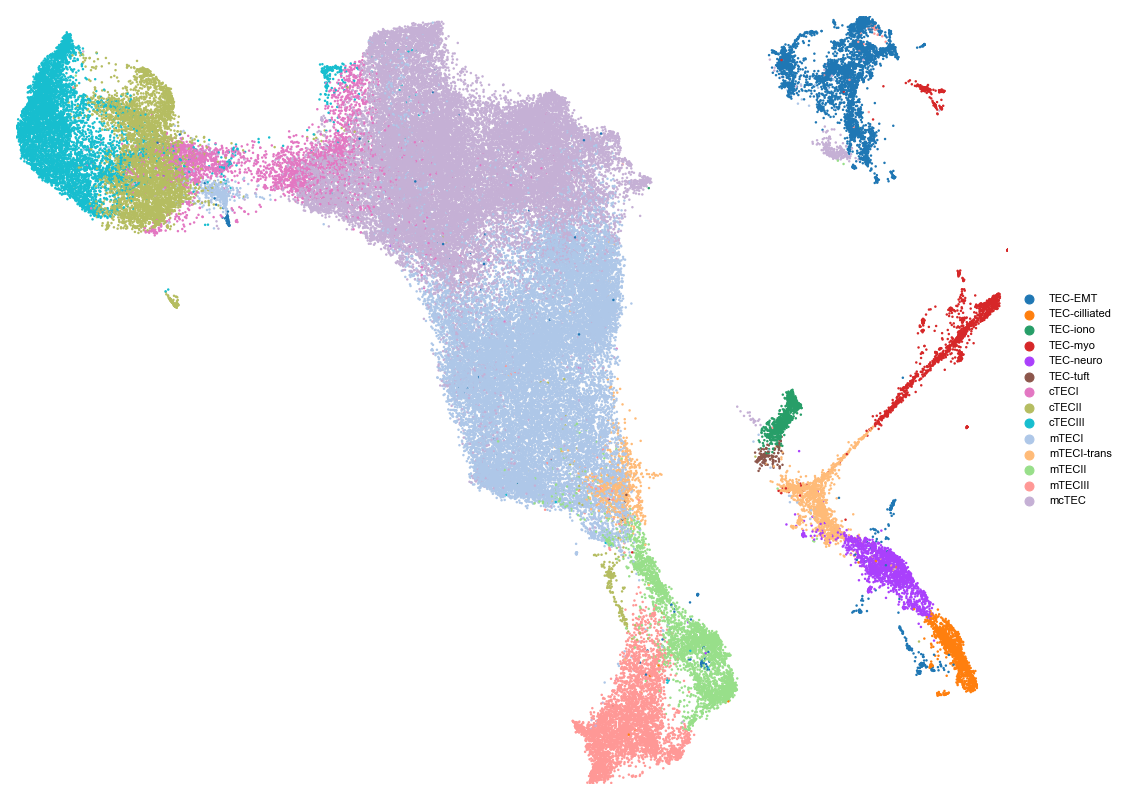

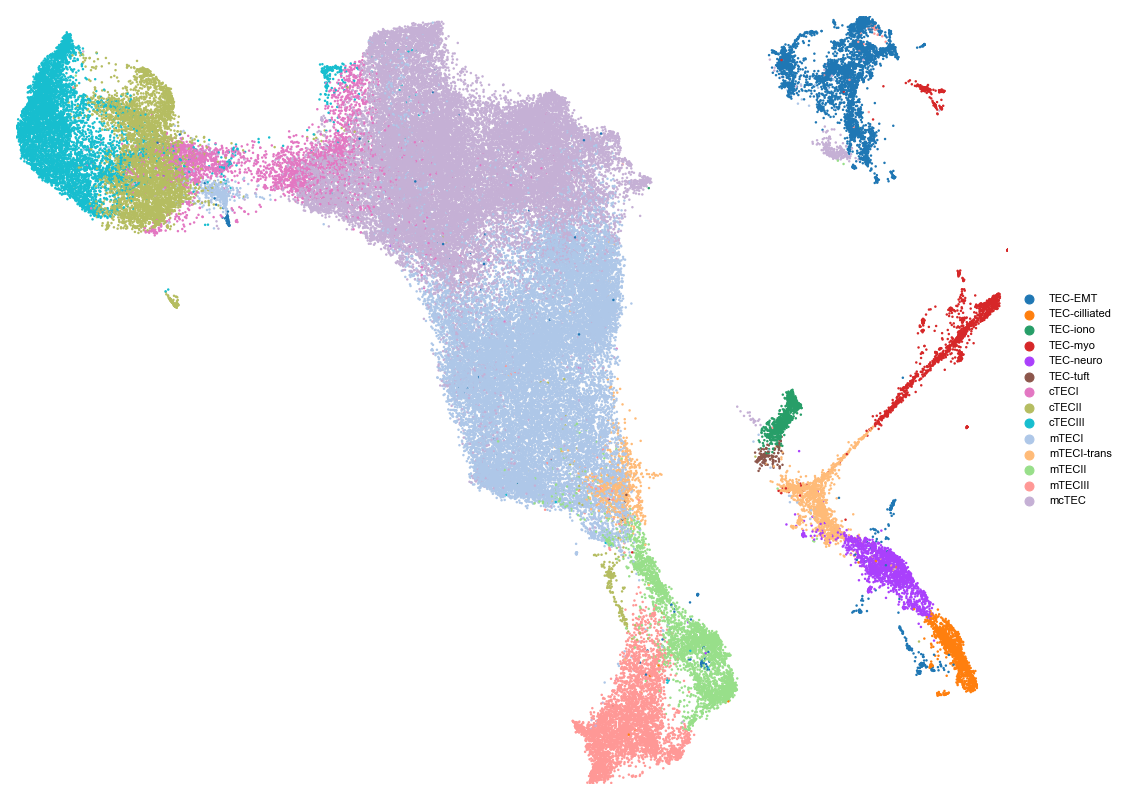

In [12]:
sc.pl.umap(adata, color = 'taa_l5', size = 5, frameon = False, return_fig = True, title = '')

In [ ]:
sc.pl.umap(adata, color = 'taa_l5', size = 5, frameon = False, return_fig = True, title = '').savefig(f'{plot_path}/thyAgeing_TEC_taa_l5_umap.png', bbox_inches='tight')

In [ ]:
sc.pl.umap(adata, color = 'taa_l5', size = 5, frameon = False, return_fig = True, title = '').savefig(f'{plot_path}/thyAgeing_TEC_taa_l5_umap.pdf', bbox_inches='tight')

In [ ]:
## Create marker plots

In [60]:
tec_mrkrs = {'pan-cTEC':['CCL25', 'HLA-DRA', 'LY75', 'PSMB11', 'KRT8', 'KRT18'],
        'cTEC\nsubtypes':['TBATA', 'TP53AIP1', 'DLL4'],
        'mcTEC':['DLK2','IGFBP6', 'IGFBP5', 'CCN2', 'CCL2'],
        'stem\nmarkers': ['KRT15', 'KRT18', 'KRT19', 'BCAM', 'ITGA6', 'MKI67'],
        'pan-mTEC': ['EPCAM', 'KRT5', 'KRT14'],
        'mTECI': ['CCL19','CCL21', 'ASCL1'],
        'EMT': ['VIM', 'TWIST1', 'ZEB1'],
        'mTECII': ['AIRE', 'FEZF2','CRIP1', 'CLDN3', 'CLDN4'], 
        'mTECIII':['SLPI', 'IVL', 'KRT10','CDKN2A'],
        'pan-neuro TEC': ['BEX1', 'NEUROD1'],
        'neuroTEC': ['NEUROG1', 'NEUROD4'], 
        'cilliated TEC': ['PCP4', 'FOXJ1'], 
        'myoTEC':['CHRNA1', 'MYOG', 'TTN'],
        'ionocytes':['FOXI1', 'CFTR'],
        'tuft cells':['POU2F3','PLCB2', 'TRPM5', 'CHAT']}

In [25]:
tec_fine_ctypes = ['cTECIII',
 'cTECII',
 'cTECI',
 'mcTEC',
 'TEC-EMT',
 'mTECI',
 'mTECII',
 'mTECIII',
 'mTECI-trans',
 'TEC-neuro',
 'TEC-cilliated',
 'TEC-myo',
 'TEC-iono',
 'TEC-tuft']

In [16]:
from plotting.utils import plot_grouped_boxplot,thyAgeing_colors

Width exceeds the maximum width of 183 mm


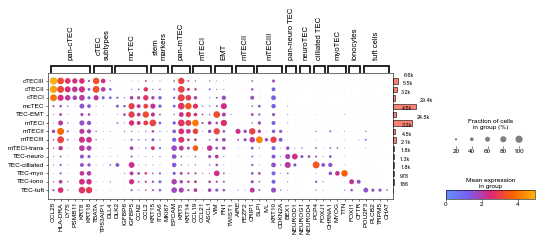

In [30]:
sc.pl.DotPlot(adata, 
            categories_order=tec_fine_ctypes,
            groupby = 'taa_l5',
            var_names=tec_mrkrs,
            figsize = calc_figsize(width = 200, height = 50),
            mean_only_expressed=True,
            cmap = sns.blend_palette([thyAgeing_colors['blue'], thyAgeing_colors['purple'], thyAgeing_colors['magenta'], thyAgeing_colors['orange'], thyAgeing_colors['yellow']], as_cmap=True,), #'magma',
            ).style(smallest_dot=0, largest_dot = 40, dot_edge_lw=0.05).add_totals(size = 0.5).savefig(f'{plot_path}/thyAgeing_TEC_taa-l5_TEC_Markers_dotplot.pdf') 

In [63]:
plt.style.use('/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')


Width exceeds the maximum width of 183 mm


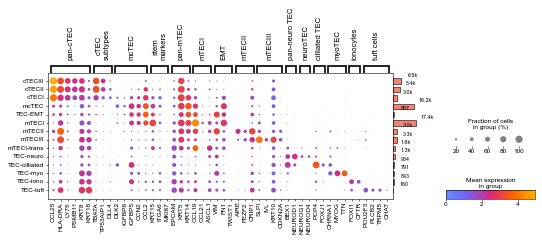

In [31]:
sc.pl.DotPlot(adata[adata.obs['age_group'].isin(['infant', 'paed'])], 
            categories_order=[i for i in tec_fine_ctypes if i in adata.obs['taa_l5'].unique()],
            groupby = 'taa_l5',
            var_names=tec_mrkrs,
            figsize = calc_figsize(width = 200, height = 50),
            mean_only_expressed=True,
            cmap = sns.blend_palette([thyAgeing_colors['blue'], thyAgeing_colors['purple'], thyAgeing_colors['magenta'], thyAgeing_colors['orange'], thyAgeing_colors['yellow']], as_cmap=True,), #'magma',
            ).style(smallest_dot=0, largest_dot = 40, dot_edge_lw=0.05).add_totals(size = 0.5).savefig(f'{plot_path}/thyAgeing_TEC_taa-l5_TEC_Markers_dotplot_epaed.pdf') 

Width exceeds the maximum width of 183 mm


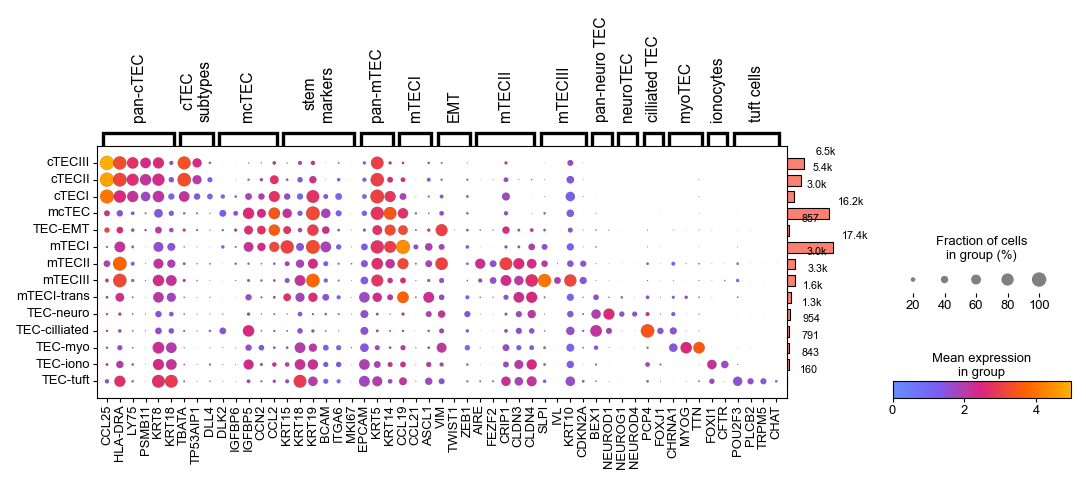

In [65]:
sc.pl.DotPlot(adata[adata.obs['age_group'].isin(['infant', 'paed'])], 
            categories_order=[i for i in tec_fine_ctypes if i in adata.obs['taa_l5'].unique()],
            groupby = 'taa_l5',
            var_names=tec_mrkrs,
            figsize = calc_figsize(width = 200, height = 50),
            mean_only_expressed=True,
            cmap = sns.blend_palette([thyAgeing_colors['blue'], thyAgeing_colors['purple'], thyAgeing_colors['magenta'], thyAgeing_colors['orange'], thyAgeing_colors['yellow']], as_cmap=True,), #'magma',
            ).style(smallest_dot=0, largest_dot = 40, dot_edge_lw=0.05).add_totals(size = 0.5).savefig(f'{plot_path}/thyAgeing_TEC_taa-l5_TEC_Markers_dotplot_epaed_v2.pdf') 

Width exceeds the maximum width of 183 mm


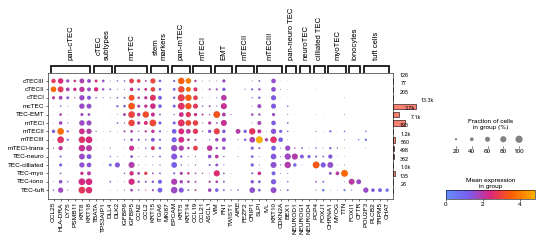

In [32]:
sc.pl.DotPlot(adata[~adata.obs['age_group'].isin(['infant', 'paed']),], 
            categories_order=[i for i in tec_fine_ctypes if i in adata.obs['taa_l5'].unique()],
            groupby = 'taa_l5',
            var_names=tec_mrkrs,
            figsize = calc_figsize(width = 200, height = 50),
            mean_only_expressed=True,
            cmap = sns.blend_palette([thyAgeing_colors['blue'], thyAgeing_colors['purple'], thyAgeing_colors['magenta'], thyAgeing_colors['orange'], thyAgeing_colors['yellow']], as_cmap=True,), #'magma',
            ).style(smallest_dot=0, largest_dot = 40, dot_edge_lw=0.05).add_totals(size = 0.5).savefig(f'{plot_path}/thyAgeing_TEC_taa-l5_TEC_Markers_dotplot_adult.pdf') 

## Plot expression of genes involved in steroid synthesis

In [44]:
sc.settings.set_figure_params(dpi = 100, color_map = 'RdPu', dpi_save = 150, vector_friendly = True, format = 'pdf')

In [35]:
steroid_lig_dict = {'progesterone': ['CYP11A1'], 
                    'estrogen_all': ['CYP19A1', 'HSD17B1'],
                    'androgen_all': ['CYP17A1', 'CYB5A'],
                    'androgen_testo1': ['CYP17A1','CYB5A', 'HSD17B3'],
                    'androgen_testo2': ['CYP17A1','CYB5A', 'AKR1C3'],
                    'cortisol': ['CYP21A2', 'CYP11B1'],
                    'vitamin_d': ['CYP27B1'],
                    'aldosterone': ['CYP11B2'],
                   }

In [46]:
steroid_rec_dict = {'progesterone': ['PGR', 'PAQR5', 'PAQR6', 'PAQR7', 'PAQR8', 'PAQR9'], 
                    'estrogen_all': ['ESR1', 'ESR2', 'GPER1'],
                    'androgen_all': ['AR'],
                    'cortisol': ['NR3C1'],
                    'aldosterone': ['NR3C2'],
                    'vitamin_d': ['VDR'],
                   }

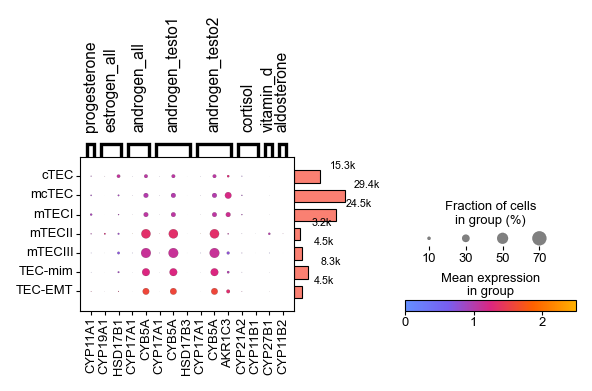

In [73]:
sc.pl.dotplot(adata,
            categories_order=[i for i in tec_broad_ctypes if i in adata.obs['taa_l3'].unique()],
            groupby = 'taa_l3', var_names = steroid_lig_dict,
            vmin = 0, vmax = 2.5, vcenter= 1.25, var_group_rotation=90, dot_max=0.7,
            swap_axes= False, mean_only_expressed=True, cmap = cmap_blend, return_fig=True, figsize=(4,1.2)).style(smallest_dot=0, 
            largest_dot = 40, dot_edge_lw=0.05).add_totals(size = 0.5).savefig(f'{plot_path}/thyAgeing_TEC_taa-l3_steroid_ligands_dotplot_all.pdf')

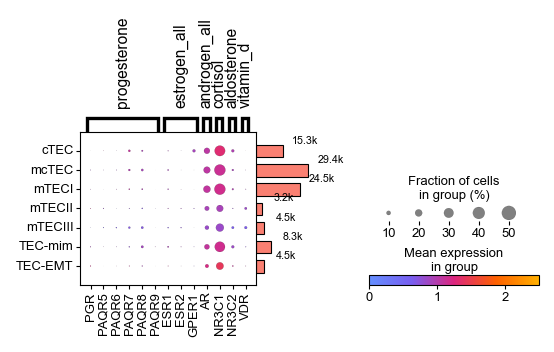

In [74]:
sc.pl.dotplot(adata,
            categories_order=[i for i in tec_broad_ctypes if i in adata.obs['taa_l3'].unique()],
            groupby = 'taa_l3', var_names = steroid_rec_dict,
            vmin = 0, vmax = 2.5, vcenter= 1.25, dot_max=0.5,
            swap_axes= False, mean_only_expressed=True, cmap = cmap_blend, return_fig=True, figsize=(3.7,1.2)).style(smallest_dot=0,
             largest_dot = 40, dot_edge_lw=0.05).add_totals(size = 0.5).savefig(f'{plot_path}/thyAgeing_TEC_taa-l3_steroid_receptors_dotplot_all.pdf')

## Plotting frequencies

In [75]:
sample_cnts = adata.obs['sample'].value_counts()
filtered_samples = sample_cnts[sample_cnts>100].index.tolist()
# Create anno df
anno_df = adata.obs[['sample', 'donor', 'sex', 'sort', 'study', col_age_group, 'age_months' ,col_cell_type_broad, col_cell_type_fine, 'pri_anno']].copy()
anno_df_filt = anno_df[(anno_df['sample'].isin(filtered_samples))].copy()
anno_df_filt.head()


,sample,donor,sex,sort,study,age_group,age_months,taa_l3,taa_l4,pri_anno
TA13072046-GGACGTCGTCTCTTAT,A67-THY-0-SC-FACS-3_5GEX,A67,M,EPCAM+CD205+,Thymus_ageing,adult,240,mTECIII,mTECIII,mTEC
TA13072046-GAATGAATCGAGAGCA,A67-THY-0-SC-FACS-3_5GEX,A67,M,EPCAM+CD205+,Thymus_ageing,adult,240,mcTEC,mcTEC,mTEC-pri
TA13072046-CTGATAGAGAATCTCC,A67-THY-0-SC-FACS-3_5GEX,A67,M,EPCAM+CD205+,Thymus_ageing,adult,240,mcTEC,mcTEC,mTEC-pri
TA13072046-CTGGTCTTCCGAAGAG,A67-THY-0-SC-FACS-3_5GEX,A67,M,EPCAM+CD205+,Thymus_ageing,adult,240,mTECI,mTECI,mTEC
TA13072046-TGAGAGGAGACAAAGG,A67-THY-0-SC-FACS-3_5GEX,A67,M,EPCAM+CD205+,Thymus_ageing,adult,240,mTECIII,mTECIII,mTEC


In [76]:
freq_df_fine = freq_by_donor(anno_df_filt, sample_col = 'sample', 
                             donor_col = 'donor', summary_col=col_cell_type_fine, 
                             add_meta = [col_age_group])

freq_df_broad = freq_by_donor(anno_df_filt, sample_col = 'sample', 
                             donor_col = 'donor', summary_col=col_cell_type_broad, 
                             add_meta = [col_age_group])

freq_df_pri = freq_by_donor(anno_df_filt, sample_col = 'sample', 
                             donor_col = 'donor', summary_col='pri_anno', 
                             add_meta = [col_age_group])


In [78]:
from plotting.utils import plot_grouped_boxplot,thyAgeing_colors,thyAgeing_greys,get_tint_palette

/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:91: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([x, hue]).agg(n_obs=(y, 'count'), mean=(y, lambda v: round(v.mean(), 4)), sd=(y, lambda v: round(v.std(), 4)), median=(y, lambda v: round(v.median(), 4))).to_csv(f'{save_stats}_summaryStats.csv', float_format='%.4f')
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:411: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kruskal_results = data.groupby(grouping_var).apply(lambda k: kruskal(*[k.loc[k[x] == g, y] for g in k[x].un

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:150: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Frequency'>

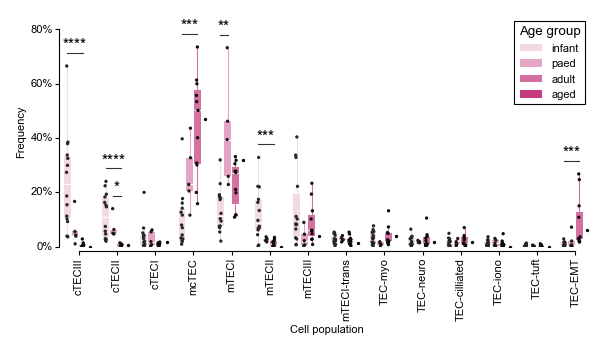

In [83]:
plot_grouped_boxplot(data = freq_df_fine, x = col_cell_type_fine, y = 'mean_prop', hue = col_age_group, 
                     order = [c for c in tec_fine_ctypes if c in freq_df_fine[col_cell_type_fine].unique().tolist()], 
                     hue_order = col_age_group_levels, x_label = 'Cell population', y_label = 'Frequency', 
                     legend_title = 'Age group', add_stats = True, format_percent = True, 
                     figsize = (3.8, 2.2), remove_legend = False,
                     palette  = get_tint_palette(thyAgeing_colors['magenta']), 
                     save_stats = f'{results_path}/thyAgeing_TEC_{col_cell_type_fine}_freq_LM_style')

plt.savefig(f'{plot_path}/thyAgeing_TEC_{col_cell_type_fine}_freq_LM_style_boxplot_pink.pdf')

/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:91: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([x, hue]).agg(n_obs=(y, 'count'), mean=(y, lambda v: round(v.mean(), 4)), sd=(y, lambda v: round(v.std(), 4)), median=(y, lambda v: round(v.median(), 4))).to_csv(f'{save_stats}_summaryStats.csv', float_format='%.4f')
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:411: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kruskal_results = data.groupby(grouping_var).apply(lambda k: kruskal(*[k.loc[k[x] == g, y] for g in k[x].un

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:150: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Frequency'>

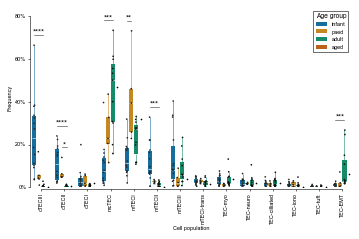

In [ ]:
plot_grouped_boxplot(data = freq_df_fine, x = col_cell_type_fine, y = 'mean_prop', hue = col_age_group, 
                     order = [c for c in tec_fine_ctypes if c in freq_df_fine[col_cell_type_fine].unique().tolist()], 
                     hue_order = col_age_group_levels, 
                     x_label = 'Cell population', y_label = 'Frequency', 
                     legend_title = 'Age group', add_stats = True, format_percent = True, 
                     figsize = (4.5,3), remove_legend = False,
                     save_stats = f'{results_path}/thyAgeing_TEC_{col_cell_type_fine}_freq_LM_style')

plt.savefig(f'{plot_path}/thyAgeing_TEC_{col_cell_type_fine}_freq_LM_style_boxplot_pres.pdf')

/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:91: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([x, hue]).agg(n_obs=(y, 'count'), mean=(y, lambda v: round(v.mean(), 4)), sd=(y, lambda v: round(v.std(), 4)), median=(y, lambda v: round(v.median(), 4))).to_csv(f'{save_stats}_summaryStats.csv', float_format='%.4f')
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:411: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kruskal_results = data.groupby(grouping_var).apply(lambda k: kruskal(*[k.loc[k[x] == g, y] for g in k[x].un

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:150: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Frequency'>

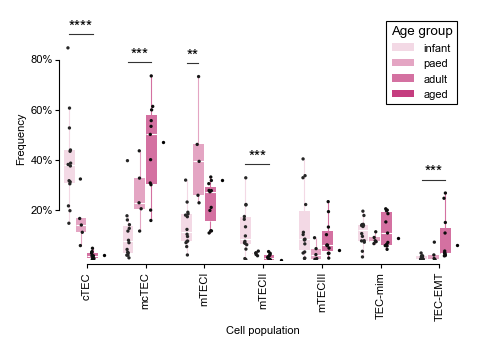

In [92]:
plot_grouped_boxplot(data = freq_df_broad, x = col_cell_type_broad, y = 'mean_prop', hue = col_age_group, 
                     order = [c for c in tec_broad_ctypes if c in freq_df_broad[col_cell_type_broad].unique().tolist()], 
                     hue_order = col_age_group_levels, 
                     x_label = 'Cell population', y_label = 'Frequency', 
                     legend_title = 'Age group', add_stats = True, format_percent = True, 
                     figsize = (3,2.2), remove_legend = False,
                     palette  = get_tint_palette(thyAgeing_colors['magenta']), 
                     save_stats = f'{results_path}/thyAgeing_TEC_{col_cell_type_broad}_freq_LM_style')

plt.savefig(f'{plot_path}/thyAgeing_TEC_{col_cell_type_broad}_freq_LM_style_boxplot_pink.pdf')

/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:91: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([x, hue]).agg(n_obs=(y, 'count'), mean=(y, lambda v: round(v.mean(), 4)), sd=(y, lambda v: round(v.std(), 4)), median=(y, lambda v: round(v.median(), 4))).to_csv(f'{save_stats}_summaryStats.csv', float_format='%.4f')
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:411: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kruskal_results = data.groupby(grouping_var).apply(lambda k: kruskal(*[k.loc[k[x] == g, y] for g in k[x].un

Performing Kruskal-Wallis and Dunn tests


<Axes: xlabel='Cell population', ylabel='Frequency'>

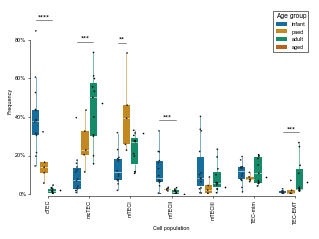

In [ ]:
plot_grouped_boxplot(data = freq_df_broad, x = col_cell_type_broad, y = 'mean_prop', hue = col_age_group, 
                     order = [c for c in tec_broad_ctypes if c in freq_df_broad[col_cell_type_broad].unique().tolist()], 
                     hue_order = col_age_group_levels, 
                     x_label = 'Cell population', y_label = 'Frequency', 
                     legend_title = 'Age group', add_stats = True, format_percent = True, 
                     figsize = (4,3), remove_legend = False,
                     save_stats = f'{results_path}/thyAgeing_TEC_{col_cell_type_broad}_freq_LM_style')

plt.savefig(f'{plot_path}/thyAgeing_TEC_{col_cell_type_broad}_freq_LM_style_boxplot_pres.pdf')

In [86]:
var = 'pri_anno'
freq_df_pri[var].unique()
tec_pri_ctypes = ['cTEC-pri', 'unpri', 'mTEC-pri']
freq_df_pri_format = freq_df_pri.loc[(freq_df_pri['pri_anno'].isin(tec_pri_ctypes)) & 
                                     (freq_df_pri[col_age_group].isin(['infant', 'paed', 'adult'])),]
freq_df_pri_format['age_group']= freq_df_pri_format['age_group'].astype(str).copy()
freq_df_pri_format['pri_anno']= freq_df_pri_format['pri_anno'].astype(str).copy()

['EMT-pri', 'TEC-EMT', 'cTEC', 'cTEC-pri', 'mTEC', 'mTEC-pri', 'unpri']
Categories (7, object): ['EMT-pri', 'TEC-EMT', 'cTEC', 'cTEC-pri', 'mTEC', 'mTEC-pri', 'unpri']

/tmp/ipykernel_866214/2569619407.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freq_df_pri_format['age_group']= freq_df_pri_format['age_group'].astype(str).copy()
/tmp/ipykernel_866214/2569619407.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freq_df_pri_format['pri_anno']= freq_df_pri_format['pri_anno'].astype(str).copy()


from scipy.stats import kruskal
len(freq_df_pri_format.groupby('pri_anno').apply(lambda k: [k.loc[k['age_group'] == g, 'mean_prop'] for g in k['age_group'].unique() if len(k.loc[k['age_group'] == g, 'mean_prop']) > 0])[2])

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:124: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.boxplot(
/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:150: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Frequency'>

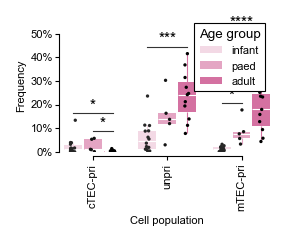

In [90]:
plot_grouped_boxplot(data = freq_df_pri_format, 
                     x = 'pri_anno', y = 'mean_prop', hue = col_age_group, 
                     order = tec_pri_ctypes, 
                     hue_order = ['infant', 'paed', 'adult'], 
                     x_label = 'Cell population', y_label = 'Frequency', 
                     legend_title = 'Age group', add_stats = True, format_percent = True, 
                     figsize = (1.8,1.5), remove_legend = False,
                        palette  = get_tint_palette(thyAgeing_colors['magenta']),
                     save_stats = f'{results_path}/thyAgeing_TEC_pri_anno_freq_LM_style')

plt.savefig(f'{plot_path}/thyAgeing_TEC_pri_anno_freq_LM_style_boxplot_pink.pdf')

Performing Kruskal-Wallis and Dunn tests


/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/utils.py:150: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  g = sns.stripplot(data=data, x=x, y=y, order=order, dodge=True, jitter=True, hue=hue, hue_order=hue_order, size=1.5,


<Axes: xlabel='Cell population', ylabel='Frequency'>

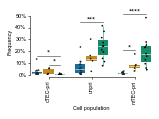

In [117]:
plot_grouped_boxplot(data = freq_df_pri_format, 
                     x = 'pri_anno', y = 'mean_prop', hue = col_age_group, 
                     order = tec_pri_ctypes, 
                     hue_order = ['infant', 'paed', 'adult'], 
                     x_label = 'Cell population', y_label = 'Frequency', 
                     legend_title = 'Age group', add_stats = True, format_percent = True, 
                     figsize = (2,1.5), remove_legend = True)
                     #save_stats = f'{results_path}/thyAgeing_TEC_pri_anno_freq_LM_style')

plt.savefig(f'{plot_path}/thyAgeing_TEC_pri_anno_freq_LM_style_boxplot_pres_v2.pdf')

### Plot stacked barplots of frequencies

In [14]:
sum(adata.obs['taa_l5'].isnull())

0

In [13]:
sample_cnts = adata.obs['sample'].value_counts()
filtered_samples = sample_cnts[sample_cnts>100].index.tolist()
# Create anno df
anno_df = adata.obs[['sample', 'donor', 'sex', 'sort', 'study', col_age_group, 'age_months' ,col_cell_type_broad, col_cell_type_fine, 'pri_anno']].copy()
anno_df_filt = anno_df[(anno_df['sample'].isin(filtered_samples))].copy()
anno_df_filt.head()


,sample,donor,sex,sort,study,age_group,age_months,taa_l3,taa_l4,pri_anno
TA13072046-GGACGTCGTCTCTTAT,A67-THY-0-SC-FACS-3_5GEX,A67,M,EPCAM+CD205+,Thymus_ageing,adult,240,mTECIII,mTECIII,mTEC
TA13072046-GAATGAATCGAGAGCA,A67-THY-0-SC-FACS-3_5GEX,A67,M,EPCAM+CD205+,Thymus_ageing,adult,240,mcTEC,mcTEC,mTEC-pri
TA13072046-CTGATAGAGAATCTCC,A67-THY-0-SC-FACS-3_5GEX,A67,M,EPCAM+CD205+,Thymus_ageing,adult,240,mcTEC,mcTEC,mTEC-pri
TA13072046-CTGGTCTTCCGAAGAG,A67-THY-0-SC-FACS-3_5GEX,A67,M,EPCAM+CD205+,Thymus_ageing,adult,240,mTECI,mTECI,mTEC
TA13072046-TGAGAGGAGACAAAGG,A67-THY-0-SC-FACS-3_5GEX,A67,M,EPCAM+CD205+,Thymus_ageing,adult,240,mTECIII,mTECIII,mTEC


In [15]:
freq_df_fine = freq_by_donor(anno_df_filt, sample_col = 'sample', 
                             donor_col = 'donor', summary_col=col_cell_type_fine, 
                             add_meta = [col_age_group])

freq_df_broad = freq_by_donor(anno_df_filt, sample_col = 'sample', 
                             donor_col = 'donor', summary_col=col_cell_type_broad, 
                             add_meta = [col_age_group])

freq_df_pri = freq_by_donor(anno_df_filt, sample_col = 'sample', 
                             donor_col = 'donor', summary_col='pri_anno', 
                             add_meta = [col_age_group])


In [17]:
tec_broad_ctypes

['cTEC', 'mcTEC', 'mTECI', 'mTECII', 'mTECIII', 'TEC-mim', 'TEC-EMT']

In [18]:
freq_agg = freq_df_broad.groupby([col_age_group, 'taa_l3'], observed=True).agg(mean_prop = ('mean_prop', 'mean'), sd_prop = ('mean_prop', 'std')).reset_index()
freq_tot = freq_df_broad.groupby(['age_group'], observed=True).agg(mean_prop = ('mean_prop', 'sum')).reset_index()
freq_agg['rel_prop'] = freq_agg.groupby('age_group', observed=True)['mean_prop'].transform(lambda x: x / x.sum())


In [22]:
len(tec_broad_ctypes)

7

In [23]:
plot_path

'/nfs/team205/vk8/projects/thymus_ageing_atlas/TEC_compartment/plots'

<Figure size 187.402x125.984 with 0 Axes>

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

Text(0.5, 0, 'Age group')

Text(0, 0.5, 'Mean proportion')

[Text(0, 0, 'infant'),
 Text(1, 0, 'paed'),
 Text(2, 0, 'adult'),
 Text(3, 0, 'aged')]

<Figure size 187.402x125.984 with 0 Axes>

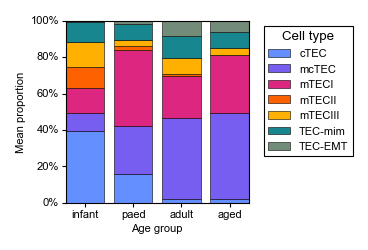

In [25]:
thyAgeing_colors = pd.read_csv('/nfs/team205/lm25/thymus_projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing_colors.csv').set_index('color_name')['hex'].to_dict()
# Plot
plt.figure(figsize=calc_figsize(width = 60, height = 40))
freq_agg_sorted = freq_agg.copy()
freq_agg_sorted['taa_l3'] = pd.Categorical(freq_agg_sorted['taa_l3'], categories=tec_broad_ctypes, ordered=True)
freq_agg_sorted['age_group'] = pd.Categorical(freq_agg_sorted['age_group'], categories=col_age_group_levels, ordered=True)

# Prepare data for stacked bar plot
fig, ax = plt.subplots(figsize=calc_figsize(width = 60, height = 40))
bottom = np.zeros(len(col_age_group_levels))

color_dict = {k:v for k, v in zip(tec_broad_ctypes, thyAgeing_colors.values())}

for ct in color_dict.keys():
    values = []
    for age in col_age_group_levels:
        val = freq_agg_sorted.loc[(freq_agg_sorted['taa_l3'] == ct) & (freq_agg_sorted['age_group'] == age), 'mean_prop']
        values.append(val.values[0] if len(val) > 0 else 0)
    color = color_dict.get(ct, '#cccccc')
    ax.bar(col_age_group_levels, values, bottom=bottom, label=ct, color=color, linewidth=0.25)
    bottom += np.array(values)

ax.set_xlabel('Age group')
ax.set_ylabel('Mean proportion')
ax.set_xticks(range(len(col_age_group_levels)))
ax.set_xticklabels(col_age_group_levels, rotation=0)
ax.legend(title='Cell type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.tight_layout()
plt.savefig(f'{plot_path}/thyAgeing_TECSplit_relTfreqFine_stackedbar.pdf')
plt.show()

In [28]:
adata.obs['sort'].unique()

array(['EPCAM+CD205+', 'TOT', 'EPCAM', 'CD45N', 'CD3P', 'CD205+CD49F+',
       'CD3N', 'CD45', 'DGC', 'CD45NCD3N'], dtype=object)

In [61]:
tec_totals = adata.obs.loc[adata.obs['sort']=='TOT'].groupby(['age_group', 'sample'], observed = True).size().reset_index(name='n_cells')
tec_totals = tec_totals.merge(adata.obs[['sample', 'donor']].drop_duplicates(), on = 'sample', how = 'left')
tec_totals['n_cells2donors'] = tec_totals.groupby('donor', observed=True)['n_cells'].transform('mean')

In [62]:
tec_totals.drop(['sample', 'n_cells'], axis = 1, inplace = True)

In [63]:
tec_totals.drop_duplicates(inplace = True)

In [64]:
tec_totals

,age_group,donor,n_cells2donors
0,adult,A16,5.375
8,adult,A43,36.500
10,adult,A45,16.000
11,adult,A51,172.000
12,adult,A53,6.000
13,adult,A56,233.000
14,adult,A67,137.000
15,adult,A70,69.000
16,adult,A72,6.000
17,adult,A74,151.500


In [65]:
tec_totals.groupby('age_group', observed=True)['n_cells2donors'].describe()

,count,mean,std,min,25%,50%,75%,max
age_group,,,,,,,,
adult,12.0,73.614583,78.890089,5.375,13.5,35.25,140.625,233.0
aged,1.0,229.000000,NaN,229.000,229.0,229.00,229.000,229.0
infant,13.0,16.500000,37.533319,3.000,4.0,5.00,8.000,141.0
paed,5.0,7.700000,4.549725,4.000,5.0,7.00,7.000,15.5


In [66]:
tec_mean_tot = tec_totals.groupby('age_group', observed=True)['n_cells2donors'].describe()[['mean']]

In [67]:
tec_mean_tot.loc[col_age_group_levels,'mean'].tolist()

[16.5, 7.7, 73.61458333333333, 229.0]

<BarContainer object of 4 artists>

Text(0.5, 0, 'Age group')

Text(0, 0.5, 'TECs per donor\n(TOT sort)')

[Text(0, 0, 'infant'),
 Text(1, 0, 'paed'),
 Text(2, 0, 'adult'),
 Text(3, 0, 'aged')]

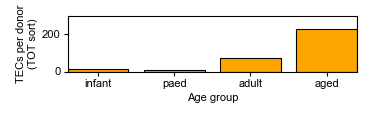

In [70]:
# Prepare data for stacked bar plot
fig, ax = plt.subplots(figsize=calc_figsize(width = 60, height = 20))
bottom = np.zeros(len(col_age_group_levels))
ax.bar(x = col_age_group_levels, height = tec_mean_tot.loc[col_age_group_levels,'mean'].tolist(), color = 'orange')
ax.set_xlabel('Age group')
ax.set_ylabel('TECs per donor\n(TOT sort)')
ax.set_xticks(range(len(col_age_group_levels)))
ax.set_xticklabels(col_age_group_levels, rotation=0)
plt.tight_layout()
plt.savefig(f'{plot_path}/thyAgeing_TECSplit_TOT_counts_mean2donor_bar.pdf')
plt.show()